# Evaluate Output

In [2]:
from utils import *
import numpy as np

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
parent_path = 'Restaurants Generations/'
meta_generation = pd.read_csv(parent_path+'meta-llama3-8b-instruct-v1:0 - full_data_100.csv')
mistral_generation =  pd.read_csv(parent_path+'mistral-mistral-7b-instruct-v0:2 - full_data_100.csv')
mistral_generation_1000 =  pd.read_csv(parent_path+'mistral-mistral-7b-instruct-v0:2 - full_data_1000.csv')
categories = ['Cuisine Type', 'Specialties', 'Dietary Options',
            'Restaurant Style', 'Atmosphere', 'Terrace', 'View', 'Price Range']
df = pd.read_csv('all_data_s3/samples/sample_1000_dining_vendors.csv')
formated_df = format_dataframe_atena(df)

### Compare for each category similarities / dissimilarities between models

In [5]:
def compare_for_category(category_name, df1_name, df2_name, df1, df2):
    compare_by_category = {'vendor_id':[], 'name':[], df1_name:[], df2_name:[], 'similar':[]}
    similar = 0
    for i in range(min(len(df1), len(df2))):
        compare_by_category['vendor_id'].append(df1['vendor_id'].values[i])
        compare_by_category['name'].append(df1['name'].values[i])
        compare_by_category[df1_name].append(df1[category].values[i])
        compare_by_category[df2_name].append(df2[category].values[i])
        if compare_by_category[df1_name][-1] == compare_by_category[df2_name][-1] :
            compare_by_category['similar'].append(1)
        elif set(word_tokenize(str(compare_by_category[df1_name][-1]))) & set(word_tokenize(str(compare_by_category[df2_name][-1]))):
            compare_by_category['similar'].append(0.5)
        else:
            compare_by_category['similar'].append(0)
        if category_name in ['View','Terrace'] and  compare_by_category['similar'][-1] == 0:
            if not check_no_anwswer(compare_by_category[df1_name][-1]) and not check_no_anwswer(str(compare_by_category[df2_name][-1])):
                compare_by_category['similar'][-1] = 0.5
    return compare_by_category

In [6]:
with pd.ExcelWriter('Restaurants Evaluation/by_category_combined.xlsx', engine='openpyxl') as writer:
    for category in categories:
        compare_by_category = compare_for_category(category, 'mistral-7b', 'meta-8b', mistral_generation, meta_generation)
        df_category = pd.DataFrame(compare_by_category)
        df_category.loc[df_category['mistral-7b'].apply(lambda x: x == []), 'mistral-7b'] = np.nan
        df_category.to_csv(f"Restaurants Evaluation/by category/{category} - mistral7B-llama8B.csv",index=False)
        df_category.to_excel(writer, sheet_name=category, index=False)

In [7]:
from IPython.display import display, HTML


metrics = {
    'Category': [],
    'No Response (Llama)': [],
    'No Response (Mistral)': [],
    "percent_similar_not_unknown": []
}

for category in categories:
    df_category = pd.read_csv(f"Restaurants Evaluation/by category/{category} - mistral7B-llama8B.csv")
    display(HTML(f"<b> Category : {category} </b>"))
    nb_mistral_unknown =  sum([1 if check_no_anwswer(prediction) else 0 for prediction in df_category['mistral-7b'].values])
    nb_mistral_or_llama_not_unknown =  sum([0 if check_no_anwswer(prediction) or check_no_anwswer(df_category['meta-8b'].values[i]) else 1 for i, prediction in enumerate(df_category['mistral-7b'].values)])
    similar_not_unknown = sum([1 if not check_no_anwswer(prediction) and not check_no_anwswer(df_category['meta-8b'].values[i] )\
                                                                           and df_category['similar'].values[i] > 0  else 0 \
                                                                           for i, prediction in enumerate(df_category['mistral-7b'].values)])
    
    metrics['Category'].append(category)
    metrics['No Response (Llama)'].append(sum([1 if check_no_anwswer(prediction) else 0 for prediction in df_category['meta-8b'].values]))
    metrics['No Response (Mistral)'].append(sum([1 if check_no_anwswer(prediction) else 0 for prediction in df_category['mistral-7b'].values]))
    metrics['percent_similar_not_unknown'].append(similar_not_unknown * 100 / nb_mistral_or_llama_not_unknown)
    
    print("Nombre de fois où Llama ne donne pas de réponse : ",metrics['No Response (Llama)'][-1])
    print("Nombre de fois où Mistral ne donne pas de réponse : ", metrics['No Response (Mistral)'][-1])
    print("Nombre de fois où Mistral et Llama trouvent l'information : ", nb_mistral_or_llama_not_unknown)
    print("Nombre de réponses similaires : ", len(df_category[df_category['similar'] > 0]))
    print(f"Nombre de réponses similaires qui ne sont pas Unknown: {similar_not_unknown} soit : {metrics['percent_similar_not_unknown'][-1]:.2f} % des cas où les deux trouvent l'information")


Nombre de fois où Llama ne donne pas de réponse :  42
Nombre de fois où Mistral ne donne pas de réponse :  21
Nombre de fois où Mistral et Llama trouvent l'information :  55
Nombre de réponses similaires :  63
Nombre de réponses similaires qui ne sont pas Unknown: 44 soit : 80.00 % des cas où les deux trouvent l'information


Nombre de fois où Llama ne donne pas de réponse :  12
Nombre de fois où Mistral ne donne pas de réponse :  6
Nombre de fois où Mistral et Llama trouvent l'information :  86
Nombre de réponses similaires :  97
Nombre de réponses similaires qui ne sont pas Unknown: 86 soit : 100.00 % des cas où les deux trouvent l'information


Nombre de fois où Llama ne donne pas de réponse :  76
Nombre de fois où Mistral ne donne pas de réponse :  84
Nombre de fois où Mistral et Llama trouvent l'information :  13
Nombre de réponses similaires :  43
Nombre de réponses similaires qui ne sont pas Unknown: 12 soit : 92.31 % des cas où les deux trouvent l'information


Nombre de fois où Llama ne donne pas de réponse :  18
Nombre de fois où Mistral ne donne pas de réponse :  20
Nombre de fois où Mistral et Llama trouvent l'information :  72
Nombre de réponses similaires :  56
Nombre de réponses similaires qui ne sont pas Unknown: 45 soit : 62.50 % des cas où les deux trouvent l'information


Nombre de fois où Llama ne donne pas de réponse :  11
Nombre de fois où Mistral ne donne pas de réponse :  18
Nombre de fois où Mistral et Llama trouvent l'information :  77
Nombre de réponses similaires :  34
Nombre de réponses similaires qui ne sont pas Unknown: 27 soit : 35.06 % des cas où les deux trouvent l'information


Nombre de fois où Llama ne donne pas de réponse :  71
Nombre de fois où Mistral ne donne pas de réponse :  70
Nombre de fois où Mistral et Llama trouvent l'information :  23
Nombre de réponses similaires :  88
Nombre de réponses similaires qui ne sont pas Unknown: 23 soit : 100.00 % des cas où les deux trouvent l'information


Nombre de fois où Llama ne donne pas de réponse :  76
Nombre de fois où Mistral ne donne pas de réponse :  74
Nombre de fois où Mistral et Llama trouvent l'information :  21
Nombre de réponses similaires :  93
Nombre de réponses similaires qui ne sont pas Unknown: 21 soit : 100.00 % des cas où les deux trouvent l'information


Nombre de fois où Llama ne donne pas de réponse :  41
Nombre de fois où Mistral ne donne pas de réponse :  48
Nombre de fois où Mistral et Llama trouvent l'information :  42
Nombre de réponses similaires :  60
Nombre de réponses similaires qui ne sont pas Unknown: 28 soit : 66.67 % des cas où les deux trouvent l'information


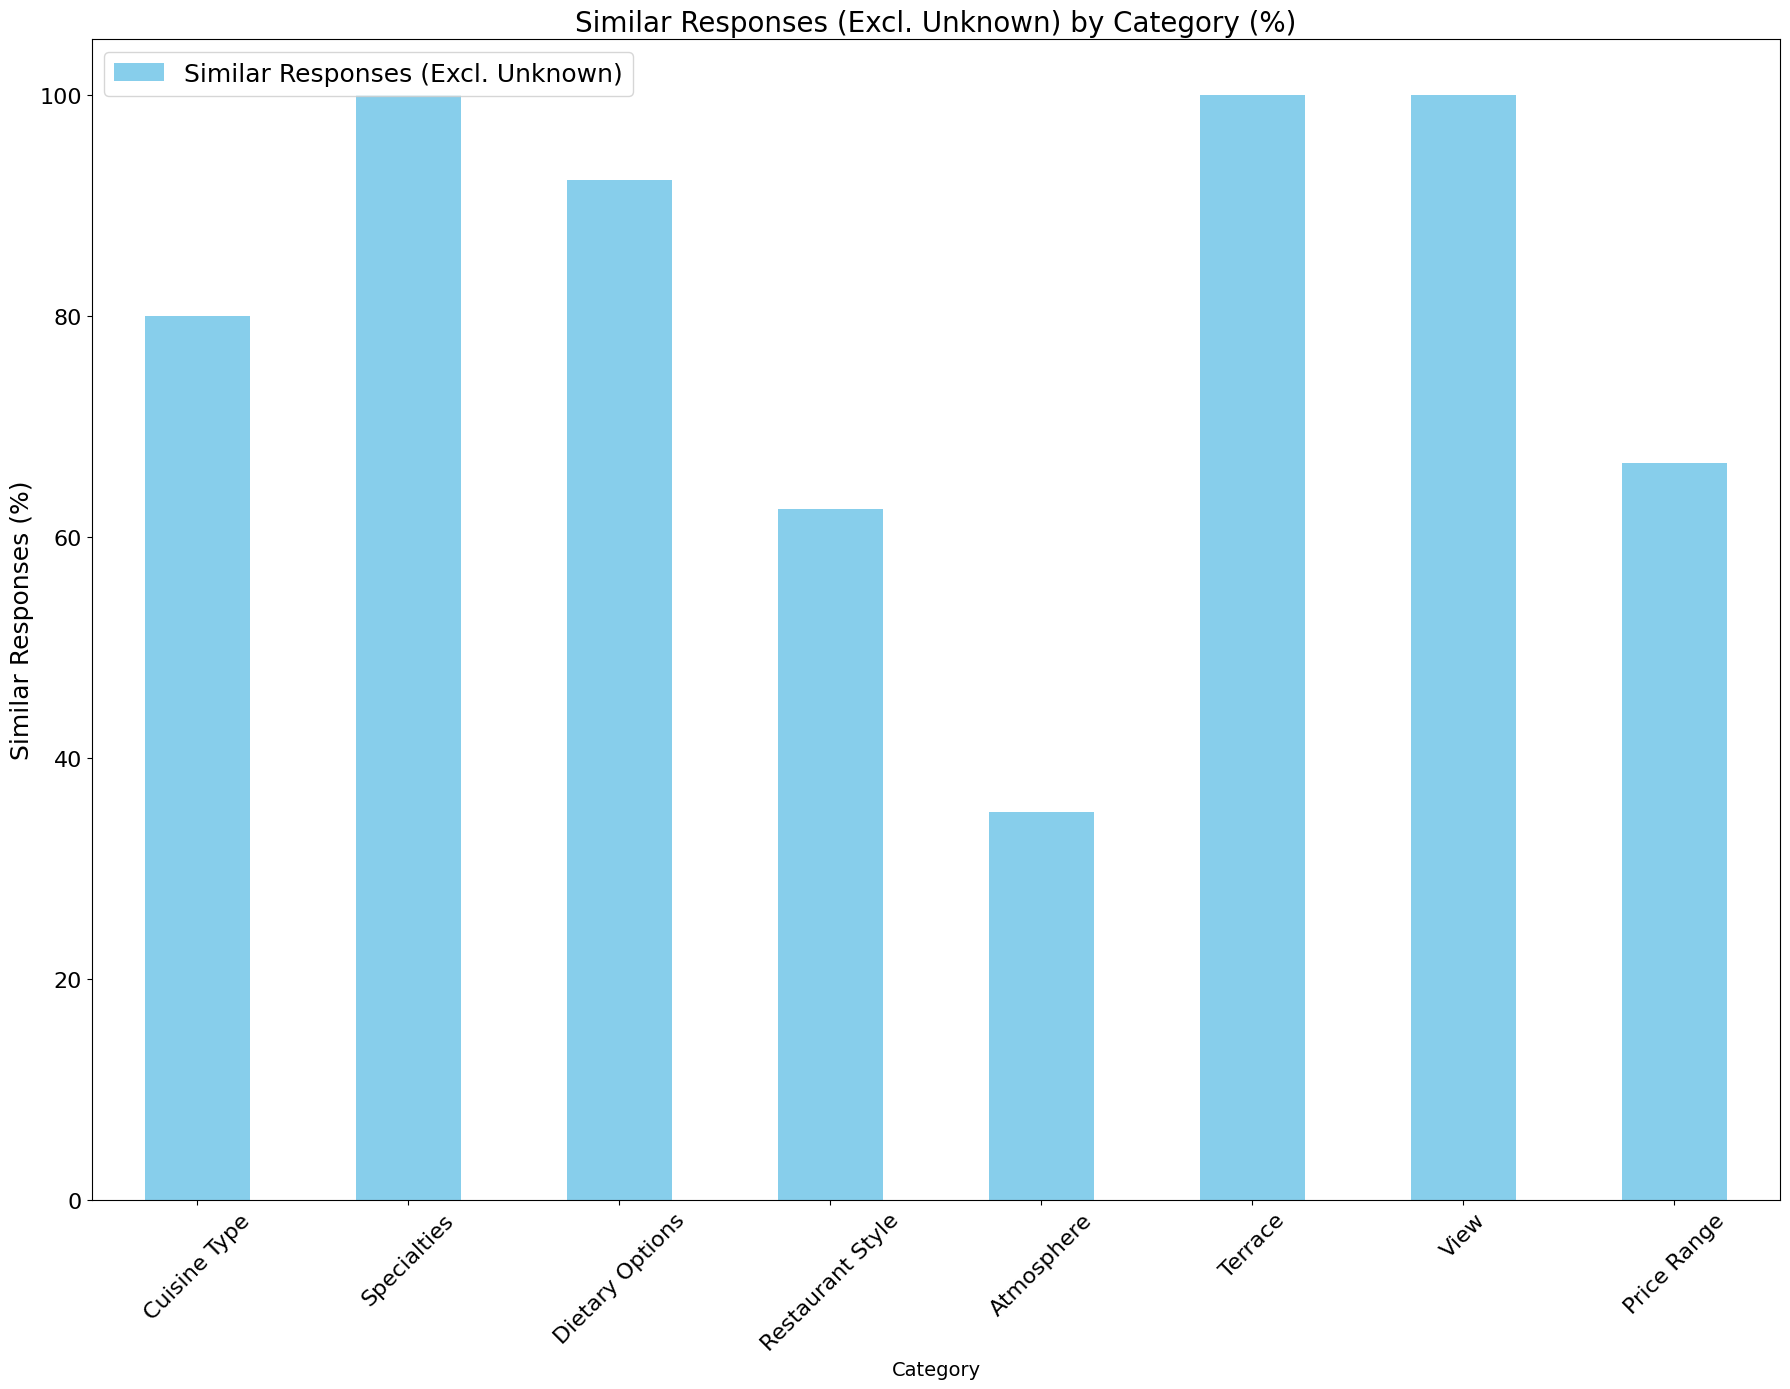

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the metrics data is already populated in `metrics`
metrics_df = pd.DataFrame({k: metrics[k] for k in ['Category', 'No Response (Llama)', 'No Response (Mistral)']})
metrics_df['Response (Llama)'] = 100 - metrics_df['No Response (Llama)']
metrics_df['Response (Mistral)'] = 100 - metrics_df['No Response (Mistral)']
percent_similarity = pd.DataFrame({k: metrics[k] for k in ['Category', 'percent_similar_not_unknown']})

# Rename the column for a better legend name
percent_similarity.rename(columns={'percent_similar_not_unknown': 'Similar Responses (Excl. Unknown)'}, inplace=True)

# Plot 1: No Response (Llama) vs No Response (Mistral)
fig1, ax1 = plt.subplots(figsize=(18, 14))  # Create a separate figure for the first plot

metrics_df.plot(kind='bar', x='Category', y=['Response (Llama)', 'Response (Mistral)'], ax=ax1, color=['skyblue', 'salmon'])

# Customize fonts for the title, labels, and ticks
ax1.set_title('Response Comparison: Llama vs Mistral by Category', fontsize=20)
ax1.set_xlabel('Category', fontsize=14)
ax1.set_ylabel('Response Frequency (%)', fontsize=18)
ax1.legend(fontsize=18)
ax1.tick_params(axis='x', rotation=45, labelsize=16)  # Rotate and increase x-tick label size
ax1.tick_params(axis='y', labelsize=16)  # Increase y-tick label size

# Save only the first plot
plt.savefig('response_comparison_figure.png', dpi=300)

# Close the first figure after saving to avoid display issues
plt.close(fig1)


# Plot 2: Percent Similar Responses (Not Unknown)
fig2, ax2 = plt.subplots(figsize=(18, 14))  # Adjusted the size to match the first figure

percent_similarity.plot(kind='bar', x='Category', y='Similar Responses (Excl. Unknown)', ax=ax2, color='skyblue')

# Customize fonts for the title, labels, and ticks similar to the first plot
ax2.set_title('Similar Responses (Excl. Unknown) by Category (%)', fontsize=20)
ax2.set_xlabel('Category', fontsize=14)
ax2.set_ylabel('Similar Responses (%)', fontsize=18)
ax2.legend(fontsize=18)  # Adding a legend with the same font size
ax2.tick_params(axis='x', rotation=45, labelsize=16)  # Rotate and increase x-tick label size
ax2.tick_params(axis='y', labelsize=16)  # Increase y-tick label size

plt.tight_layout()
plt.savefig('models_similar_answers.png', dpi=300)

# Show the second plot
plt.show()

In [ ]:

# Plot 2: Percent Similar Responses (Not Unknown)
percent_similarity.plot(kind='bar', x='Category', y='percent_similar_not_unknown', ax=ax[1], color='skyblue')

ax[1].set_title('Percent Similar Responses (Not Unknown) by Category')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Percent Similar Responses')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

# Show both plots
plt.show()

In [24]:
metrics_df

,Category,No Response (Llama),No Response (Mistral),Response (Llama),Response (Mistral)
0,Cuisine Type,42,21,58,79
1,Specialties,12,6,88,94
2,Dietary Options,76,84,24,16
3,Restaurant Style,18,20,82,80
4,Atmosphere,11,18,89,82
5,Terrace,71,70,29,30
6,View,76,74,24,26
7,Price Range,41,48,59,52


### LLM Based Evaluation

In [15]:
examples_by_category = {"Cuisine Type": "(e.g., French, Italian)",
                        "Specialties": "(specific dishes mentioned)",
                        "Dietary Options": "(e.g., vegan, gluten-free)",
                        "Restaurant Style": "(e.g., modern, rustic)",
                        "Atmosphere": "(e.g., casual, fine dining)",
                        "Terrace": "(Indicates if outdoor seating is available)",
                        "View": "(Notes if there’s a notable view)",
                        "Price Range": "(Average cost per person or general pricing)"}


question_by_features = {"Cuisine Type": f"Do you have the information that the cuisine type {examples_by_category['Cuisine Type']} is ",
                        "Specialties": f"Do you have the information that the specialties {examples_by_category['Specialties']} are ",
                        "Dietary Options": f"Do you have direct information that the dietary options {examples_by_category['Dietary Options']} are ",
                        "Restaurant Style": f"Do you have the information that the restaurant style {examples_by_category['Restaurant Style']} is ",
                        "Atmosphere": f"Do you have the information that the atmosphere of the restaurant {examples_by_category['Atmosphere']} is ",
                        "Terrace": f"Do you have the information that the restaurant has a terrace ?",
                        "View": f"Do you have the information that the restaurant has a view ?",
                        "Price Range": f"Do you have the information that the price range of the restaurant is "}
validate_unknown = "Is there any information about "

In [36]:
llm = create_llm(region='us-west-2', model_id='meta.llama3-1-70b-instruct-v1:0',max_tokens=2)
#model_id='mistral.mistral-large-2402-v1:0',max_tokens=2)

In [37]:
template_with_answer = """
Instruction :
Answer with yes or no, maximum 2 tokens:
#####
Example :
Based on the following restaurant reviews:
I really liked the pizza

Do you have the information that the cuisine type is French?
Answer: No
#####

Based on the following restaurant reviews: ////{reviews}////
\n{question}{llm_answer}
Answer:"""
template_without_answer = """
Instruction :
Answer with yes or no:
#####
Example :
Based on the following restaurant reviews:
I really liked the pizza

Is there any information about Terrace (Indicates if outdoor seating is available) ?
Answer: No
#####

Based on the following restaurant reviews: ////{reviews}////
\n{question}{category} {example} ?
Answer:"""
prompt_with_answer = PromptTemplate(
    input_variables=["reviews", "question", "llm_answer"],
    template=template_with_answer
)
llm_chain_with_answer = prompt_with_answer | llm
prompt_without_answer = PromptTemplate(
    input_variables=["reviews", "question", "category", "example"],
    template=template_without_answer
)
llm_chain_without_answer = prompt_without_answer | llm

In [38]:
def generate_evaluation_dataset(df_reviews_and_predictions, verbose=False):
        evaluation = {feature: {"correct" : 0, "incorrect": 0} for feature in question_by_features}
        details_evaluation = {feature: {"correct" : {}, "incorrect": {}, "problem":[]} for feature in question_by_features}
        llm_answers = {}
        for i, row in df_reviews_and_predictions.iterrows():
            print(i)
            llm_answers[row['vendor_id']] = {}
            try:
                if row['reviews']:
                    reviews = "\n".join([review['text'] for review in eval(row['reviews'])])
                    for category, question in question_by_features.items():
                        if "Unknown" in row[category]:
                            answer = llm_chain_without_answer.invoke({"reviews":reviews, "question": validate_unknown, "category": category, "example": examples_by_category[category]})
                            if 'yes' in answer.lower():
                                evaluation[category]["incorrect"] += 1
                                details_evaluation[category]["incorrect"] |= {row["vendor_id"]: row[category]}
                            else:
                                evaluation[category]["correct"] += 1
                                details_evaluation[category]["correct"] |= {row["vendor_id"]: row[category]}
                        else:
                            answer = llm_chain_with_answer.invoke({"reviews":reviews, "question": question_by_features[category], "llm_answer": row[category]})
                            if 'yes' in answer.lower():
                                evaluation[category]['correct'] += 1
                                details_evaluation[category]["correct"] |= {row["vendor_id"]: row[category]}
                            else:
                                evaluation[category]['incorrect'] += 1
                                details_evaluation[category]["incorrect"] |= {row["vendor_id"]: row[category]}
                        llm_answers[row['vendor_id']][category] = answer
                        
                        if verbose:
                            if "Unknown" in row[category]:
                                question_prompt = prompt_without_answer.invoke({"reviews":reviews, "question": validate_unknown, "category": category, "example": examples_by_category[category]})
                            else:
                                question_prompt = prompt_with_answer.invoke({'reviews':reviews, 'question': question_by_features[category], 'llm_answer': row[category]})
                            print(f"Category : {category}\nQuestion : {question_prompt}\nAnswer : {answer}")
                            print('------------------------------------------------------')
            except Exception as e:
                print(e)
                details_evaluation[category]["problem"].append(row["vendor_id"])
                
        return evaluation, details_evaluation, llm_answers

In [ ]:
llama_evaluation, llama_details_evaluation, llama_llm_answers = generate_evaluation_dataset(meta_generation)

In [1]:
evaluation_parent_path = "Restaurants Evaluation"

In [40]:
json.dump(llama_evaluation, open(f'{evaluation_parent_path}/llama_evaluation_llama_large_evaluator.json','w'))
json.dump(llama_details_evaluation, open(f'{evaluation_parent_path}/llama_details_evaluation_llama_large_evaluator.json','w'))
json.dump(llama_llm_answers, open(f'{evaluation_parent_path}/llama_llm_answers_llama_large_evaluator.json','w'))

In [ ]:
mistral_evaluation, mistral_details_evaluation, mistral_llm_answers = generate_evaluation_dataset(mistral_generation)
json.dump(mistral_evaluation, open(f'{evaluation_parent_path}/mistral_evaluation_llama_large_evaluator.json','w'))
json.dump(mistral_details_evaluation, open(f'{evaluation_parent_path}/mistral_details_evaluation_llama_large_evaluator.json','w'))
json.dump(mistral_llm_answers, open(f'{evaluation_parent_path}/mistral_llm_answers_llama_large_evaluator.json','w'))

## Plot Evaluation Metrics based on LLM Evaluators

In [12]:
import json

# load_evaluation_details
evaluation_parent_path = "Restaurants Evaluation"


models = ['llama','mistral']
evaluations = {}
for model in models:
    evaluations[model] = {}
    for evaluator in models:
        evaluations[model][f"evaluator_{evaluator}"] = json.load(open(f"{evaluation_parent_path}/{model}_evaluation_{evaluator}_large_evaluator.json", 'r'))

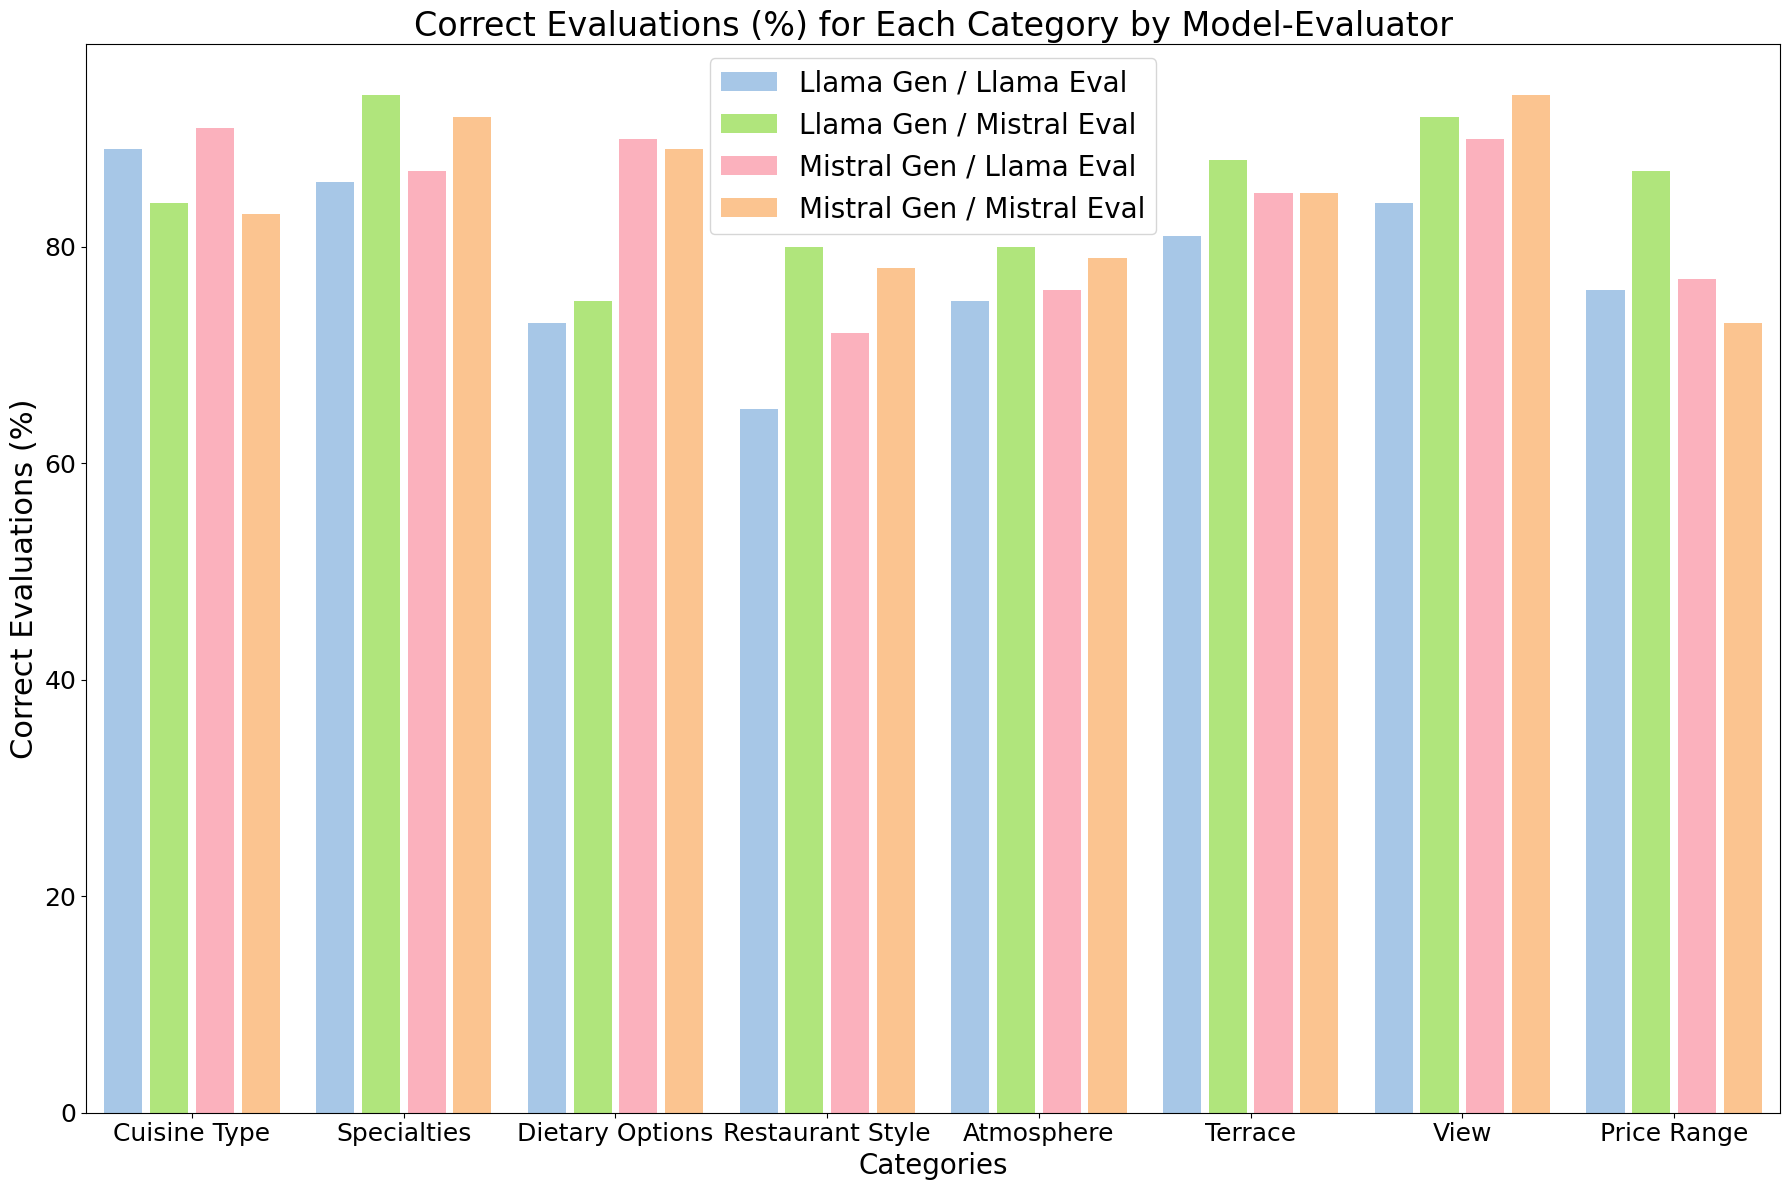

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract correct evaluations for each model-evaluator pair for each category
llama_evaluator_llama = [evaluations['llama']['evaluator_llama'][category]['correct'] for category in categories]
llama_evaluator_mistral = [evaluations['llama']['evaluator_mistral'][category]['correct'] for category in categories]
mistral_evaluator_llama = [evaluations['mistral']['evaluator_llama'][category]['correct'] for category in categories]
mistral_evaluator_mistral = [evaluations['mistral']['evaluator_mistral'][category]['correct'] for category in categories]

# Setting up bar locations and width
x = np.arange(len(categories))  # label locations
width = 0.18  # reduce width slightly to create more space between groups

# Creating the plot
fig, ax = plt.subplots(figsize=(18, 12))  # Increased figure size for better readability

# Plot bars with improved legend names
bars1 = ax.bar(x - 1.8*width, llama_evaluator_llama, width, label='Llama Gen / Llama Eval', color='#A7C7E7')
bars2 = ax.bar(x - 0.6*width, llama_evaluator_mistral, width, label='Llama Gen / Mistral Eval', color='#B0E57C')
bars3 = ax.bar(x + 0.6*width, mistral_evaluator_llama, width, label='Mistral Gen / Llama Eval', color='#FBB1BD')
bars4 = ax.bar(x + 1.8*width, mistral_evaluator_mistral, width, label='Mistral Gen / Mistral Eval', color='#FBC490')

# Adding labels and title with increased font size
ax.set_xlabel('Categories', fontsize=20)
ax.set_ylabel('Correct Evaluations (%)', fontsize=22)
ax.set_title('Correct Evaluations (%) for Each Category by Model-Evaluator', fontsize=24)

# Increase font size for x-ticks and y-ticks
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=18)
ax.tick_params(axis='y', labelsize=18)

# Update the legend with a larger font size
ax.legend(fontsize=20)

# Slightly adjust the limits of the x-axis to create more space
ax.set_xlim([-0.5, len(categories) - 0.5])

# Display the plot
plt.tight_layout()
plt.savefig('Models_automatic_evaluation.png', dpi=300)
plt.show()


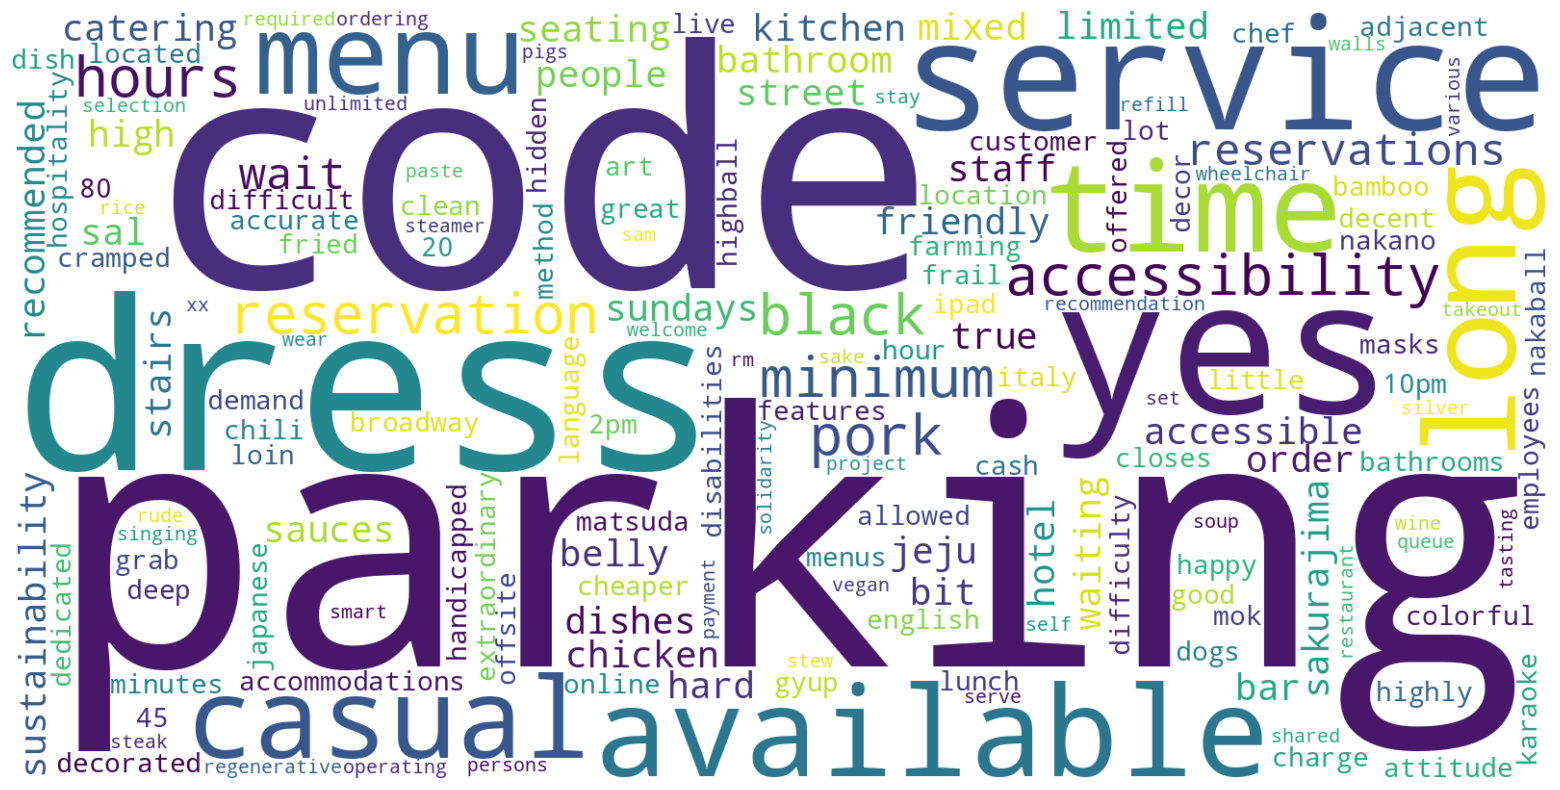

In [73]:
additional_infos = [str(eval(other_infos)['Additional Info']).replace('Unknown','') for other_infos in mistral_generation['other_infos'].values if eval(other_infos)]
ngrams_freq = get_ngrams(additional_infos,(1,1))
show_wordcloud_of_ngrams(ngrams_freq)